In [ ]:
!pip install tensorflow
!pip install matplotlib
!pip install pillow

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.utils as utils
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
# Download sample images
content_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg"
style_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg"

content_path = utils.get_file('content.jpg', content_url)
style_path = utils.get_file('style.jpg', style_url)

83281/83281 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
195196/195196 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:


# Helper functions
def load_and_process(img_path, target_size=(400, 400)):
    img = load_img(img_path, target_size=target_size)
    img = img_to_array(img)
    return vgg19.preprocess_input(np.expand_dims(img, axis=0))

def deprocess(img):
    img = img.reshape((400, 400, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    return np.clip(img[:, :, ::-1], 0, 255).astype('uint8')

def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    x = tf.reshape(tensor, [-1, channels])
    return tf.matmul(x, x, transpose_a=True)

In [4]:
# Loss functions
def compute_loss(model, content_features, style_features, generated_image):
    outputs = model(generated_image)
    content_loss = tf.reduce_mean((outputs[-1] - content_features[-1]) ** 2)
    style_loss = tf.add_n([tf.reduce_mean((gram_matrix(outputs[i]) - gram_matrix(style_features[i])) ** 2)
                           for i in range(len(style_layers))])
    total_loss = content_loss * 1.0 + style_loss * 1e-4
    return total_loss

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Iteration 0: Loss 761400930598912.0
Iteration 10: Loss 118098036260864.0
Iteration 20: Loss 43723530436608.0
Iteration 30: Loss 21073821171712.0
Iteration 40: Loss 13770663395328.0
Iteration 41: Loss 13364765917184.0


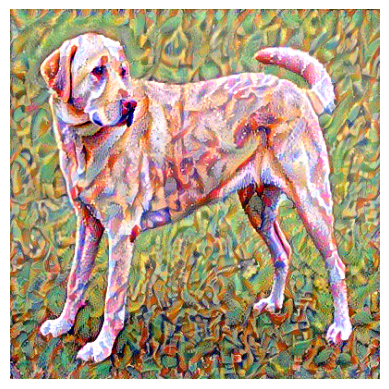

In [5]:
# Load images
content_image = load_and_process(content_path)
style_image = load_and_process(style_path)

# Model setup
vgg = vgg19.VGG19(weights='imagenet', include_top=False)
vgg.trainable = False
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
content_layer = 'block4_conv2'
outputs = [vgg.get_layer(name).output for name in style_layers + [content_layer]]
model = Model(inputs=vgg.input, outputs=outputs)

# Extract features
content_features = model(content_image)
style_features = model(style_image)

# Prepare generated image
gen_img = tf.Variable(content_image, dtype=tf.float32)
optimizer = tf.keras.optimizers.Adam(5.0)

# Training
for i in range(42):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, content_features, style_features, gen_img)
    grads = tape.gradient(loss, gen_img)
    optimizer.apply_gradients([(grads, gen_img)])
    if i % 10 == 0 or i == 41:
        print(f"Iteration {i}: Loss {loss.numpy()}")

# Show output
plt.imshow(deprocess(gen_img.numpy()))
plt.axis('off')
plt.show()